# Optimization for Training Deep Models

Reference book: http://www.deeplearningbook.org/contents/optimization.html

>If you are familier with following concept you can skip and move forwards:

    1. How Learning Diﬀers from Pure Optimization
    2. Challenges in Neural Network Optimization
    3. Basic Algorithms
    4. Parameter Initialization Strategies
    5. Algorithms with Adaptive Learning Rates
    6. Approximate Second-Order Methods
    7. Optimization Strategies and Meta-Algorithms

In [1]:
# library imports
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, './opt')
import numpy as np
import matplotlib.pyplot as plt
import ann1o as ann # the nueral network model we created in previous lecture

### 1. How Learning Diﬀers from Pure Optimization
Includes
    - Emperical Risk minimization.
    - Surrogate loss function and early stopping.
    - Batch and minibatch Algorithms.
    
> Read section 8.1 here http://www.deeplearningbook.org/contents/optimization.html

Before proceeding to minibatch gradient descent code let's get familier with new structure of our previous model given in file ann10.py in opt folder.... let's check if model works....

We will try to fit a quadratic data


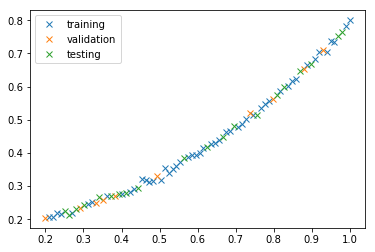

In [2]:
# defining the data to fit.......
np.random.seed(18)
n_points = 80
# we are limiting the output to 0 to one since the output node gives probability between 0 to 1
X = np.linspace(0,0.8,n_points).reshape(n_points,1)
np.random.shuffle(X)
X = X.T + 0.2
Y = abs(X**2)+np.random.randn(1,n_points)*0.01  + 0.3
Y = 0.8*Y/np.max(Y)
print("We will try to fit a quadratic data")
# defining training data
tr_size = 60
x_tr = X[0,:tr_size].reshape(1,tr_size)
y_tr = Y[0,:tr_size].reshape(1,tr_size)
x_te = X[0,tr_size:].reshape(1,n_points-tr_size)
y_te = Y[0,tr_size:].reshape(1,n_points-tr_size)
# defining validation data
str_size = 50
x_str = x_tr[0,:str_size].reshape(1,str_size)
y_str = y_tr[0,:str_size].reshape(1,str_size)
x_val = x_tr[0,str_size:].reshape(1,tr_size-str_size)
y_val = y_tr[0,str_size:].reshape(1,tr_size-str_size)
plt.clf()
plt.plot(x_str.T,y_str.T,'x',label = 'training')
plt.plot(x_val.T,y_val.T,'x',label = 'validation')
plt.plot(x_te.T,y_te.T,'x',label = 'testing')
plt.legend()
plt.show()

In [ ]:
layers = [1,15,1]  # layer structure
actis = ['none','relu','sigmoid'] # activation at each layer
hyperparams = {
    'learning_rate': 0.9,
    'structural_reg' : 'dout',
    'structural_lambda' : 0.5, 
    'lambdaa' : 0.001,
    'regulization' : 'none', 
    'early_stop' : True, 
    'max_passes' : 1000, 
    'max_epochs' : 150000, 
    'display_cost' : True, 
    'cost_interval' : 10000, 
    'plot_cost'   : True,
}

In [ ]:
ann1 = ann.NN(layers, actis, hyperparams)
ann1.train(x_str, y_str, x_val, y_val)

In [ ]:
pY = ann1.predict(x_te)
print("Predicted fit.....")
err = np.sum((pY - y_te)**2)/y_te.shape[1]
print("The MSE is : ", err)
plt.plot(x_te.T,pY.T,'.')
plt.plot(x_te.T,y_te.T,'.')
plt.show()

The use classes helps us to extend or scale our model freely so<br>
Now we can start minibatch gradient descent ........

In [ ]:
# minibatch gradient descent
class mbatch_NN(ann.NN):
    
    def create_batches(self, x, y, k):
        [n,m] = x.shape
        self.batches = {}
        siz = m//k
        perm = np.random.permutation(m)
        xd = x[:,perm]
        yd = y[:,perm]
        
        for i in range(k):
            if (i == k-1):
                self.batches['bx'+ str(i)] = xd[:,i*siz:].reshape(n,-1)
                self.batches['by'+ str(i)] = yd[:,i*siz:].reshape(n,-1)
            else:
                self.batches['bx'+ str(i)] = xd[:,i*siz:(i+1)*siz].reshape(n,siz)
                self.batches['by'+ str(i)] = yd[:,i*siz:(i+1)*siz].reshape(n,siz)
                
    def train_batches(self, x_str,y_str,xval,yval, k):
        np.random.seed(1)
        costs = []  # keep track of cost

        [n, m] = x_str.shape

        valcst = 10 ** 5
        passes = 0
        oparams = self.parameters
        
        self.create_batches(x_str, y_str, k)
        
        for i in range(0, self.num_epochs):
            for j in range(k):
                
                X = self.batches['bx'+ str(j)]
                Y = self.batches['by'+ str(j)]
                a3, caches, masks = self.lmodelfwd(X)

                if (self.plotcost):
                    cost = self.compcost(a3, Y)

                grads = self.lmodelback(a3, Y, caches, masks)

                self.parameters = self.updateparams(grads, self.ld / m)
                
                
            if (self.plotcost):
                if self.print_cost and i % self.printerval == 0:
                    print("Cost after iteration %i: %f" % (i, cost))
                if i % self.printerval == 0:
                    costs.append(cost)

            if (self.estop and i % 10 == 0):
                yvald = self.predict(xval)
                vcost = self.compcost(yvald, yval)
                if (vcost < valcst):
                    passes = 0
                    valcst = vcost
                    oparams = self.parameters
                else:
                    if (passes > self.max_passes):
                        self.parameters = oparams
                        print("breaking the loop........")
                        break
                    else:
                        passes = passes + 1

        # plot the cost
        if (self.plotcost):
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations /' + str(self.printerval))
            plt.title("Learning rate =" + str(self.learning_rate))
            plt.show()
            
        self.costs.append(costs)

In [ ]:
layers = [1,15,1]  # layer structure
actis = ['none','relu','sigmoid'] # activation at each layer
hyperparams = {
    'learning_rate': 0.9,
    'structural_reg' : 'dout',
    'structural_lambda' : 0.5, 
    'lambdaa' : 0.001,
    'regulization' : 'none', 
    'early_stop' : True, 
    'max_passes' : 1000, 
    'max_epochs' : 150000, 
    'display_cost' : True, 
    'cost_interval' : 10000, 
    'plot_cost'   : True,
}

ann2 = mbatch_NN(layers, actis, hyperparams)
ann2.train_batches(x_str, y_str, x_val, y_val, 4)

In [ ]:
pY = ann2.predict(x_te)
print("Predicted fit.....")
err = np.sum((pY - y_te)**2)/y_te.shape[1]
print("The MSE is : ", err)
plt.plot(x_te.T,pY.T,'.')
plt.plot(x_te.T,y_te.T,'.')
plt.show()

### 2. Challenges in Neural Network Optimization



I would ask you to read section 8.2 from the book although it's all theoritical it includes the pitfalls of nueral network optimization which can save you in pinch so please read section 8.2 here http://www.deeplearningbook.org/contents/optimization.html

### 3. Basic Algorithms

#### 3.1 Stochastic Gradient Descent (SGD)

In [ ]:
# minibatch gradient descent
class stochastic_NN(ann.NN):
              
    def train_stochastic(self, x_str,y_str,xval,yval, batch_size=1, num_iter = None, init_lr = None):
        if(num_iter == None):
            num_iter = self.num_epochs
        if(init_lr == None):
            init_lr = self.learning_rate
            
            
        self.learning_rate = init_lr
        self.num_epochs = num_iter
        np.random.seed(1)
        costs = []  # keep track of cost

        [n, m] = x_str.shape

        valcst = 10 ** 5
        passes = 0
        oparams = self.parameters
        olddiff = 0
        diff = 0
        mincost = valcst
        
        knb = m//batch_size
        
        for i in range(0, self.num_epochs):
            
            for j in range(knb):
                
                lb = j*batch_size
                ub = min(m,(j+1)*batch_size)
                siz = ub-lb
                X = x_str[:,lb:ub].reshape(n,siz)
                Y = y_str[:,lb:ub].reshape(n,siz)
                a3, caches, masks = self.lmodelfwd(X)

                grads = self.lmodelback(a3, Y, caches, masks)

                self.parameters = self.updateparams(grads, self.ld / m)
            
            cost = self.compcost(a3, Y)
            
            if (mincost > cost):
                mincost = cost
                olddiff = diff
                diff = cost-mincost
                self.learning_rate = min(self.learning_rate*(np.sign(olddiff-diff)*0.01+1),0.9)
            else:
                olddiff = diff
                diff = cost-mincost
                self.learning_rate = min(self.learning_rate*(np.sign(olddiff-diff)*0.01+1),0.9)
            
                
            if (self.print_cost):
                if i % self.printerval == 0:
                    print("Cost after iteration", i, ' is:', cost,':: l_rate',self.learning_rate)
            if (self.plotcost):
                if i % self.printerval == 0:
                    costs.append(cost)

            if (self.estop and i % 10 == 0):
                yvald = self.predict(xval)
                vcost = self.compcost(yvald, yval)
                if (vcost < valcst):
                    passes = 0
                    valcst = vcost
                    oparams = self.parameters
                else:
                    if (passes > self.max_passes):
                        self.parameters = oparams
                        print("breaking the loop........")
                        break
                    else:
                        passes = passes + 1

        # plot the cost
        if (self.plotcost):
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations /' + str(self.printerval))
            plt.title("Learning rate =" + str(self.learning_rate))
            plt.show()
            
        self.costs.append(costs)

In [ ]:
layers = [1,15,1]  # layer structure
actis = ['none','relu','sigmoid'] # activation at each layer
hyperparams = {
    'learning_rate': 0.9,
    'structural_reg' : 'dout',
    'structural_lambda' : 0.5, 
    'lambdaa' : 0.001,
    'regulization' : 'none', 
    'early_stop' : True, 
    'max_passes' : 1000, 
    'max_epochs' : 20000, 
    'display_cost' : True, 
    'cost_interval' : 1000, 
    'plot_cost'   : True,
}

ann3 = stochastic_NN(layers, actis, hyperparams)
ann3.train_stochastic(x_str, y_str, x_val, y_val,batch_size = 3)

In [ ]:
pY = ann3.predict(x_te)
print("Predicted fit.....")
err = np.sum((pY - y_te)**2)/y_te.shape[1]
print("The MSE is : ", err)
plt.plot(x_te.T,pY.T,'.')
plt.plot(x_te.T,y_te.T,'.')
plt.show()

#### 3.2 Momentum  

In [ ]:
class momentum_NN(ann.NN):
    def init_velocity(self):
        self.velocity = {}
        for l in range(1, self.L):
            self.velocity['W' + str(l)] = self.parameters['W' + str(l)]*0
            self.velocity['b' + str(l)] = self.parameters['b' + str(l)]*0
            
    def update_velocity(self, grads, ldbym, alpha):
        L = len(self.parameters) // 2  # number of layers in the neural network
        
        # Update rule for each parameter. Use a for loop.
        for l in range(L):
            
            if (self.reg == 'l2reg'):
                self.velocity["W" + str(l+1)] = alpha*self.velocity["W" + str(l+1)] + (1-alpha)*(grads[
                    "dW" + str(l + 1)] + ldbym*self.parameters["W" + str(l + 1)])
                
            elif (self.reg == 'l1reg'):
                self.velocity["W" + str(l+1)] = alpha*self.velocity["W" + str(l+1)]
                - (1-alpha)*self.learning_rate*(grads["dW" + str(l + 1)] + ldbym*np.sign(self.parameters["W" + str(l + 1)]))
                
            else:
                self.velocity["W" + str(l+1)] = alpha*self.velocity["W" + str(l+1)] + (1-alpha)*(grads[
                    "dW" + str(l + 1)])   
                                                                                                          
            self.velocity["b" + str(l+1)] = alpha*self.velocity["b" + str(l+1)] + (1-alpha)*(grads[
                    "db" + str(l + 1)]) 
            
        l = 0
        for l in range(L):
            assert(self.velocity["W" + str(l+1)].shape == self.parameters["W" + str(l+1)].shape)
            self.parameters["W" + str(l+1)] = self.parameters["W" + str(l+1)] - self.learning_rate*self.velocity["W" + str(l+1)]
            self.parameters["b" + str(l+1)] = self.parameters["b" + str(l+1)] - self.learning_rate*self.velocity["b" + str(l+1)]
                                                                                                          
        return self.parameters
    
    def train_momentum(self, x_str,y_str,xval,yval, batch_size=1, num_iter = None, init_lr = None, alpha = 0.9):
       
        self.init_velocity()
        
        if(num_iter == None):
            num_iter = self.num_epochs
        if(init_lr == None):
            init_lr = self.learning_rate
            
            
        self.learning_rate = init_lr
        self.num_epochs = num_iter
        np.random.seed(1)
        costs = []  # keep track of cost

        [n, m] = x_str.shape

        valcst = 10 ** 5
        passes = 0
        oparams = self.parameters
        olddiff = 0
        diff = 0
        mincost = valcst
        
        knb = m//batch_size
        
        for i in range(0, self.num_epochs):
            
            for j in range(knb):
                
                lb = j*batch_size
                ub = min(m,(j+1)*batch_size)
                siz = ub-lb
                X = x_str[:,lb:ub].reshape(n,siz)
                Y = y_str[:,lb:ub].reshape(n,siz)
                a3, caches, masks = self.lmodelfwd(X)

                grads = self.lmodelback(a3, Y, caches, masks)
                
                self.parameters = self.update_velocity(grads, self.ld / m, alpha)
            
            cost = self.compcost(a3, Y)
            
            if (mincost > cost):
                mincost = cost
                olddiff = diff
                diff = cost-mincost
                self.learning_rate = min(self.learning_rate*(np.sign(olddiff-diff)*0.01+1),0.9)
            else:
                olddiff = diff
                diff = cost-mincost
                self.learning_rate = min(self.learning_rate*(np.sign(olddiff-diff)*0.01+1),0.9)
            
                
            if (self.print_cost):
                if i % self.printerval == 0:
                    print("Cost after iteration", i, ' is:', cost,':: l_rate',self.learning_rate)
            if (self.plotcost):
                if i % self.printerval == 0:
                    costs.append(cost)

            if (self.estop and i % 10 == 0):
                yvald = self.predict(xval)
                vcost = self.compcost(yvald, yval)
                if (vcost < valcst):
                    passes = 0
                    valcst = vcost
                    oparams = self.parameters
                else:
                    if (passes > self.max_passes):
                        self.parameters = oparams
                        print("breaking the loop........")
                        break
                    else:
                        passes = passes + 1

        # plot the cost
        if (self.plotcost):
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations /' + str(self.printerval))
            plt.title("Learning rate =" + str(self.learning_rate))
            plt.show()
        
        self.costs.append(costs)

In [ ]:
layers = [1,15,1]  # layer structure
actis = ['none','relu','sigmoid'] # activation at each layer
hyperparams = {
    'learning_rate': 0.9,
    'structural_reg' : 'dout',
    'structural_lambda' : 0.5, 
    'lambdaa' : 0.001,
    'regulization' : 'none', 
    'early_stop' : True, 
    'max_passes' : 1000, 
    'max_epochs' : 20000, 
    'display_cost' : True, 
    'cost_interval' : 1000, 
    'plot_cost'   : True,
}

ann4 = momentum_NN(layers, actis, hyperparams)
ann4.train_momentum(x_str, y_str, x_val, y_val,batch_size = 3, alpha = 0.99)

In [ ]:
pY = ann4.predict(x_te)
print("Predicted fit.....")
err = np.sum((pY - y_te)**2)/y_te.shape[1]
print("The MSE is : ", err)
plt.plot(x_te.T,pY.T,'.')
plt.plot(x_te.T,y_te.T,'.')
plt.show()

----------------------
### 4. Parameter Initialization Strategies
    
   1. Xavier's Initialization

In [ ]:
class init_NN(ann.NN):
    def xav_init_params(self):
        np.random.seed(3)
        for l in range(1, self.L):
            a = np.sqrt(2/(self.layers[l] + self.layers[l - 1]))
            self.parameters['W' + str(l)] = np.random.uniform(-a,a,size=[self.layers[l], self.layers[l - 1]])
            self.parameters['b' + str(l)] = np.zeros((self.layers[l], 1))
        

In [ ]:
layers = [1,15,1]  # layer structure
actis = ['none','relu','sigmoid'] # activation at each layer
hyperparams = {
    'learning_rate': 0.9,
    'structural_reg' : 'dout',
    'structural_lambda' : 0.5, 
    'lambdaa' : 0.001,
    'regulization' : 'none', 
    'early_stop' : True, 
    'max_passes' : 1000, 
    'max_epochs' : 20000, 
    'display_cost' : True, 
    'cost_interval' : 100, 
    'plot_cost'   : True,
}

ann5 = init_NN(layers, actis, hyperparams)
ann5.train(x_str, y_str, x_val, y_val)
cost1 = ann5.costs
pY1 = ann5.predict(x_te)
ann5.costs = []
ann5.xav_init_params()
ann5.train(x_str, y_str, x_val, y_val)
cost2 = ann5.costs
pY2 = ann5.predict(x_te)

In [ ]:
plt.plot(np.squeeze(cost1))
plt.plot(np.squeeze(cost2))
plt.ylabel('cost')
plt.xlabel('iterations /' + str(ann5.printerval))
plt.title("Learning rate =" + str(ann5.learning_rate))
plt.show()
print("Predicted fit.....")
err1 = np.sum((pY1 - y_te)**2)/y_te.shape[1]
err2 = np.sum((pY2 - y_te)**2)/y_te.shape[1]
print("The MSE1 is : ", err1)
print("The MSE2 is : ", err2)
plt.plot(x_te.T,pY1.T,'.')
plt.plot(x_te.T,pY2.T,'.')
plt.plot(x_te.T,y_te.T,'.')
plt.show()

### 5. Algorithms with Adaptive Learning Rates

#### 5.1 AdaGrad

In [ ]:
class adagrad_NN(ann.NN):
    def update_adagrad(self, grads, ldbym):
        ep = 10**-8
        L = len(self.parameters) // 2  # number of layers in the neural network
        # Update rule for each parameter. Use a for loop.
        for l in range(L):
            if (self.reg == 'l2reg'):
                grads["dW" + str(l + 1)] = grads["dW" + str(l + 1)] + ldbym*self.parameters["W" + str(l + 1)]
            elif (self.reg == 'l1reg'):
                grads["dW" + str(l + 1)] = grads["dW" + str(l + 1)] + ldbym*np.sign(self.parameters["W" + str(l + 1)])
            else:
                pass
                
            self.R['W'+str(l+1)] = self.R['W'+str(l+1)] + grads['dW'+str(l+1)]**2
            deno = np.sqrt(self.R['W' + str(l+1)] + ep)
            
            self.parameters["W" + str(l + 1)] = self.parameters["W" + str(l + 1)] - (self.learning_rate/deno) * grads["dW" + str(l + 1)]

            self.R['b'+str(l+1)] = self.R['b'+str(l+1)] + grads['db'+str(l+1)]**2
            deno = np.sqrt(self.R['b' + str(l+1)] + ep)
            self.parameters["b" + str(l + 1)] = self.parameters["b" + str(l + 1)] - (self.learning_rate/deno) * grads["db" + str(l + 1)]
            
        return self.parameters
    
    def train_adagrad(self, x_str,y_str,xval,yval, batch_size=None, num_iter = None, init_lr = None):
        self.R = {}
        for l in range(1, self.L):
            self.R['W' + str(l)] = np.zeros((self.layers[l], self.layers[l - 1]))
            self.R['b' + str(l)] = np.zeros((self.layers[l], 1))
            
        
        if(num_iter == None):
            num_iter = self.num_epochs
        if(init_lr == None):
            init_lr = self.learning_rate
        if(batch_size == None):
            batch_size = x_str.shape[1]
            
            
        self.learning_rate = init_lr
        self.num_epochs = num_iter
        np.random.seed(1)
        costs = []  # keep track of cost

        [n, m] = x_str.shape

        valcst = 10 ** 5
        passes = 0
        oparams = self.parameters
        olddiff = 0
        diff = 0
        mincost = valcst
        
        knb = m//batch_size
        
        for i in range(0, self.num_epochs):
            
            for j in range(knb):
                
                lb = j*batch_size
                ub = min(m,(j+1)*batch_size)
                siz = ub-lb
                X = x_str[:,lb:ub].reshape(n,siz)
                Y = y_str[:,lb:ub].reshape(n,siz)
                a3, caches, masks = self.lmodelfwd(X)

                grads = self.lmodelback(a3, Y, caches, masks)

                self.parameters = self.update_adagrad(grads, self.ld / m)
            
            cost = self.compcost(a3, Y)
        
            
                
            if (self.print_cost):
                if i % self.printerval == 0:
                    print("Cost after iteration", i, ' is:', cost)
            if (self.plotcost):
                if i % self.printerval == 0:
                    costs.append(cost)

            if (self.estop and i % 10 == 0):
                yvald = self.predict(xval)
                vcost = self.compcost(yvald, yval)
                if (vcost < valcst):
                    passes = 0
                    valcst = vcost
                    oparams = self.parameters
                else:
                    if (passes > self.max_passes):
                        self.parameters = oparams
                        print("breaking the loop........")
                        break
                    else:
                        passes = passes + 1

        # plot the cost
        if (self.plotcost):
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations /' + str(self.printerval))
            plt.title("Learning rate =" + str(self.learning_rate))
            plt.show()
            
        self.costs.append(costs)


In [ ]:
layers = [1,15,1]  # layer structure
actis = ['none','relu','sigmoid'] # activation at each layer
hyperparams = {
    'learning_rate': 0.9,
    'structural_reg' : 'dout',
    'structural_lambda' : 0.5, 
    'lambdaa' : 0.001,
    'regulization' : 'none', 
    'early_stop' : True, 
    'max_passes' : 1000, 
    'max_epochs' : 20000, 
    'display_cost' : True, 
    'cost_interval' : 1000, 
    'plot_cost'   : True,
}

ann6 = adagrad_NN(layers, actis, hyperparams)
ann6.train_adagrad(x_str, y_str, x_val, y_val, batch_size = 3)

In [ ]:
pY = ann6.predict(x_te)
print("Predicted fit.....")
err = np.sum((pY - y_te)**2)/y_te.shape[1]
print("The MSE is : ", err)
plt.plot(x_te.T,pY.T,'.')
plt.plot(x_te.T,y_te.T,'.')
plt.show()

#### 5.2 AdaDelta / RmsProp

In [ ]:
class rmsprop_NN(ann.NN):
    def update_rmsprop(self, grads, ldbym):
        ep = 10**-6
        L = len(self.parameters) // 2  # number of layers in the neural network
        # Update rule for each parameter. Use a for loop.
        for l in range(L):
            if (self.reg == 'l2reg'):
                grads["dW" + str(l + 1)] = grads["dW" + str(l + 1)] + ldbym*self.parameters["W" + str(l + 1)]
            elif (self.reg == 'l1reg'):
                grads["dW" + str(l + 1)] = grads["dW" + str(l + 1)] + ldbym*np.sign(self.parameters["W" + str(l + 1)])
            else:
                pass
             
            
            self.R['W'+str(l+1)] = self.rho*self.R['W'+str(l+1)] + (1-self.rho)*grads['dW'+str(l+1)]**2
            deno = np.sqrt(self.R['W' + str(l+1)]) + ep
           
            self.parameters["W" + str(l + 1)] = self.parameters["W" + str(l + 1)] - (self.learning_rate/deno) * grads["dW" + str(l + 1)]

            self.R['b'+str(l+1)] = self.R['b'+str(l+1)] + grads['db'+str(l+1)]**2
            deno = np.sqrt(self.R['b' + str(l+1)]) + ep
            self.parameters["b" + str(l + 1)] = self.parameters["b" + str(l + 1)] - (self.learning_rate/deno) * grads["db" + str(l + 1)]
            
        return self.parameters
    
    def train_rmsprop(self, x_str,y_str,xval,yval,rho = 0.5, batch_size=None, num_iter = None, init_lr = None):
        self.R = {}
        self.rho = rho
        for l in range(1, self.L):
            self.R['W' + str(l)] = np.zeros((self.layers[l], self.layers[l - 1]))
            self.R['b' + str(l)] = np.zeros((self.layers[l], 1))
            
        
        if(num_iter == None):
            num_iter = self.num_epochs
        if(init_lr == None):
            init_lr = self.learning_rate
        if(batch_size == None):
            batch_size = x_str.shape[1]
            
            
        self.learning_rate = init_lr
        self.num_epochs = num_iter
        np.random.seed(1)
        costs = []  # keep track of cost

        [n, m] = x_str.shape

        valcst = 10 ** 5
        passes = 0
        oparams = self.parameters
        olddiff = 0
        diff = 0
        mincost = valcst
        
        knb = m//batch_size
        
        for i in range(0, self.num_epochs):
            
            for j in range(knb):
                
                lb = j*batch_size
                ub = min(m,(j+1)*batch_size)
                siz = ub-lb
                X = x_str[:,lb:ub].reshape(n,siz)
                Y = y_str[:,lb:ub].reshape(n,siz)
                a3, caches, masks = self.lmodelfwd(X)

                grads = self.lmodelback(a3, Y, caches, masks)

                self.parameters = self.update_rmsprop(grads, self.ld / m)
            
            cost = self.compcost(a3, Y)
        
            
                
            if (self.print_cost):
                if i % self.printerval == 0:
                    print("Cost after iteration", i, ' is:', cost)
            if (self.plotcost):
                if i % self.printerval == 0:
                    costs.append(cost)

            if (self.estop and i % 10 == 0):
                yvald = self.predict(xval)
                vcost = self.compcost(yvald, yval)
                if (vcost < valcst):
                    passes = 0
                    valcst = vcost
                    oparams = self.parameters
                else:
                    if (passes > self.max_passes):
                        self.parameters = oparams
                        print("breaking the loop........")
                        break
                    else:
                        passes = passes + 1

        # plot the cost
        if (self.plotcost):
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations /' + str(self.printerval))
            plt.title("Learning rate =" + str(self.learning_rate))
            plt.show()
            
        self.costs.append(costs)


In [ ]:
layers = [1,15,1]  # layer structure
actis = ['none','relu','sigmoid'] # activation at each layer
hyperparams = {
    'learning_rate': 0.002,
    'structural_reg' : 'dout',
    'structural_lambda' : 0.5, 
    'lambdaa' : 0.001,
    'regulization' : 'none', 
    'early_stop' : True, 
    'max_passes' : 1000, 
    'max_epochs' : 20000, 
    'display_cost' : True, 
    'cost_interval' : 1000, 
    'plot_cost'   : True,
}

ann7 = rmsprop_NN(layers, actis, hyperparams)
ann7.train_rmsprop(x_str, y_str, x_val, y_val, rho = 0.99, batch_size = 3)

In [ ]:
pY = ann7.predict(x_te)
print("Predicted fit.....")
err = np.sum((pY - y_te)**2)/y_te.shape[1]
print("The MSE is : ", err)
plt.plot(x_te.T,pY.T,'.')
plt.plot(x_te.T,y_te.T,'.')
plt.show()

#### 5.3 Adam

In [ ]:
class adam_NN(ann.NN):
    def init_velocity(self):
        self.velocity = {}
        for l in range(1, self.L):
            self.velocity['W' + str(l)] = self.parameters['W' + str(l)]*0
            self.velocity['b' + str(l)] = self.parameters['b' + str(l)]*0
            
    def update_adam(self, grads, ldbym, alpha):
        L = len(self.parameters) // 2  # number of layers in the neural network
        ep = 10**-6
        # Update rule for each parameter. Use a for loop.
        for l in range(L):
            
            if (self.reg == 'l2reg'):
                grads["dW" + str(l + 1)] = grads["dW" + str(l + 1)] + ldbym*self.parameters["W" + str(l + 1)]
            elif (self.reg == 'l1reg'):
                grads["dW" + str(l + 1)] = grads["dW" + str(l + 1)] + ldbym*np.sign(self.parameters["W" + str(l + 1)])
            else:
                pass
            
            self.R['W'+str(l+1)] = (self.rho*self.R['W'+str(l+1)] + (1-self.rho)*grads['dW'+str(l+1)]**2)
            self.cR['W'+str(l+1)] = self.R['W'+str(l+1)]/(1-self.rho**self.itern)
            self.R['b'+str(l+1)] = (self.rho*self.R['b'+str(l+1)] + (1-self.rho)*grads['db'+str(l+1)]**2)
            self.cR['b'+str(l+1)] = self.R['b'+str(l+1)]/(1-self.rho**self.itern)                        
            
            self.velocity["W" + str(l+1)] = (alpha*self.velocity["W" + str(l+1)] + (1-alpha)*(grads[
                    "dW" + str(l + 1)]))
            self.cV['W'+str(l+1)] = self.velocity['W'+str(l+1)]/(1-alpha**self.itern)
                                                                                                          
            self.velocity["b" + str(l+1)] = (alpha*self.velocity["b" + str(l+1)] + (1-alpha)*(grads[
                    "db" + str(l + 1)]))
            self.cV['b'+str(l+1)] = self.velocity['b'+str(l+1)]/(1-alpha**self.itern)
            
        l = 0
        for l in range(L):
            assert(self.velocity["W" + str(l+1)].shape == self.parameters["W" + str(l+1)].shape)
            mul = self.learning_rate/(ep + np.sqrt(self.cR['W'+str(l+1)]))
            self.parameters["W" + str(l+1)] = self.parameters["W" + str(l+1)] - mul*self.cV["W" + str(l+1)]
            mul = self.learning_rate/(ep + np.sqrt(self.cR['b'+str(l+1)]))
            self.parameters["b" + str(l+1)] = self.parameters["b" + str(l+1)] - mul*self.cV["b" + str(l+1)]
                                                                                                          
        return self.parameters
    
    def train_adam(self, x_str,y_str,xval,yval, batch_size=1, num_iter = None, init_lr = None, alpha = 0.99, rho = 0.9):
        self.itern = 0
        self.init_velocity()
        self.R = {}
        self.rho = rho
        for l in range(1, self.L):
            self.R['W' + str(l)] = np.zeros((self.layers[l], self.layers[l - 1]))
            self.R['b' + str(l)] = np.zeros((self.layers[l], 1))
              
        self.cR = self.R
        self.cV = self.velocity
            
        if(num_iter == None):
            num_iter = self.num_epochs
        if(init_lr == None):
            init_lr = self.learning_rate
            
            
        self.learning_rate = init_lr
        self.num_epochs = num_iter
        np.random.seed(1)
        costs = []  # keep track of cost

        [n, m] = x_str.shape

        valcst = 10 ** 5
        passes = 0
        oparams = self.parameters
        olddiff = 0
        diff = 0
        mincost = valcst
        
        knb = m//batch_size
        
        for i in range(0, self.num_epochs):
            
            for j in range(knb):
                self.itern = self.itern + 1
                lb = j*batch_size
                ub = min(m,(j+1)*batch_size)
                siz = ub-lb
                X = x_str[:,lb:ub].reshape(n,siz)
                Y = y_str[:,lb:ub].reshape(n,siz)
                
                a3, caches, masks = self.lmodelfwd(X)

                grads = self.lmodelback(a3, Y, caches, masks)
                
                self.parameters = self.update_adam(grads, self.ld / m, alpha)
                
                
            cost = self.compcost(a3, Y)
            
            
            
                
            if (self.print_cost):
                if i % self.printerval == 0:
                    print("Cost after iteration", i, ' is:', cost,':: l_rate',self.learning_rate)
            if (self.plotcost):
                if i % self.printerval == 0:
                    costs.append(cost)

            if (self.estop and i % 10 == 0):
                yvald = self.predict(xval)
                vcost = self.compcost(yvald, yval)
                if (vcost < valcst):
                    passes = 0
                    valcst = vcost
                    oparams = self.parameters
                else:
                    if (passes > self.max_passes):
                        self.parameters = oparams
                        print("breaking the loop........")
                        break
                    else:
                        passes = passes + 1

        # plot the cost
        if (self.plotcost):
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations /' + str(self.printerval))
            plt.title("Learning rate =" + str(self.learning_rate))
            plt.show()
        
        self.costs.append(costs)

In [ ]:
layers = [1,15,1]  # layer structure
actis = ['none','relu','sigmoid'] # activation at each layer
hyperparams = {
    'learning_rate': 0.02,
    'structural_reg' : 'dout',
    'structural_lambda' : 0.5, 
    'lambdaa' : 0.001,
    'regulization' : 'none', 
    'early_stop' : True, 
    'max_passes' : 1000, 
    'max_epochs' : 20000, 
    'display_cost' : True, 
    'cost_interval' : 1000, 
    'plot_cost'   : True,
}

ann8 = adam_NN(layers, actis, hyperparams)
ann8.train_adam(x_str, y_str, x_val, y_val, batch_size = 5, alpha = 0.9, rho = 0.99)

In [ ]:
pY = ann8.predict(x_te)
print("Predicted fit.....")
err = np.sum((pY - y_te)**2)/y_te.shape[1]
print("The MSE is : ", err)
plt.plot(x_te.T,pY.T,'.')
plt.plot(x_te.T,y_te.T,'.')
plt.show()

------------------
### 6. Approximate Second-Order Methods

Read Section 8.6 from book

------

### 7. Optimization Strategies and Meta-Algorithms